In [1]:
%cd '/home/urbanaq/cams_downscaling'

/home/urbanaq/cams_downscaling


In [2]:
from pathlib import Path
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import pandas as pd

In [3]:
REGIONS = {
    "IBERIA": {"min_lat": 35.7,
               "min_lon": -9.9,
               "max_lat": 44.1,
               "max_lon": 4.5}
}

# 0. Preprocesament

1. Temporal resampling datasets 
2. Regriding datasets (Bilinear interpolation)
3. Define Regions of Interest (ROIs) 
4. Generate station permutations for each ROI(X-1/1) 
5. Interpolate stations (X-1) (Nearest neighbours + Kriging) 
6. Add geographical proximity covariates 
7. Add interpolation covariates 

# 1. CAMS data

In [4]:
from model.dataloader import load_cams

cams_path = '/home/urbanaq/data/cams/no2/IBERIA'
#dates = pd.date_range('2022-01-01T00:00:00', '2023-12-31T23:00:00', freq='h')
dates = pd.date_range('2022-01-01T00:00:00', '2022-01-01T23:00:00', freq='h')
cams = load_cams(cams_path, dates=dates)

cams

GridData(
    > Axes:
        - date: 24 elements
        - lat: 84 elements
        - lon: 144 elements
    > Data:
        - no2: (24, 84, 144)
    > Memory: 1.11 MB
)

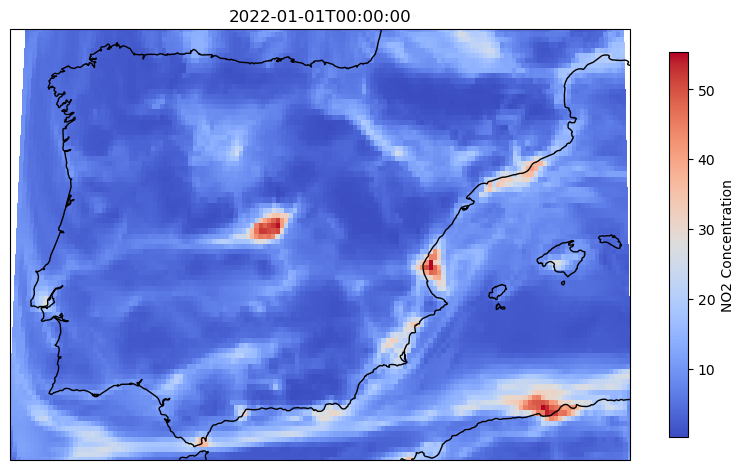

In [5]:
data = cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Define the extent
extent = (cams.lon.min(), cams.lon.max(), cams.lat.min(), cams.lat.max())

# Create a meshgrid for the coordinates
lon, lat = np.meshgrid(cams.lon, cams.lat)

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(lon, lat, data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

## 1.1. Temporal resampling

CAMS is already in hourly format, so no need to resample

## 1.2. Regridding datasets

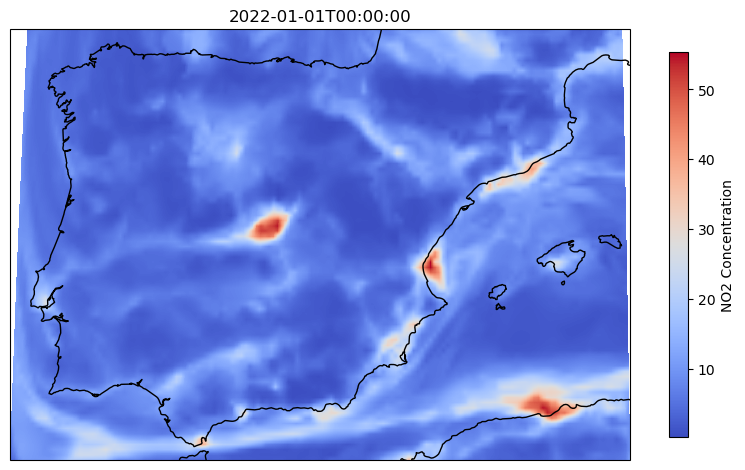

In [6]:
new_resolution = 0.01

new_lat = np.arange(cams.lat.min(), cams.lat.max(), new_resolution)
new_lon = np.arange(cams.lon.min(), cams.lon.max(), new_resolution)

new_cams = cams.interpolate(lat=new_lat, lon=new_lon)
new_data = new_cams[pd.to_datetime('2022-01-01T00:00:00'), :, :].values['no2']

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")

# Using pcolormesh for accurate pixel plotting
im = ax.pcolormesh(new_lon, new_lat, new_data.squeeze(), cmap=plt.cm.coolwarm, transform=ccrs.PlateCarree())

# Set the extent of the map
ax.set_extent(extent, crs=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.5, pad=0.05)
cbar.set_label('NO2 Concentration')

# Set the title
plt.title('2022-01-01T00:00:00')

# Show the plot
plt.show()

In [7]:
new_cams

GridData(
    > Axes:
        - date: 24 elements
        - lat: 830 elements
        - lon: 1431 elements
    > Data:
        - no2: (24, 830, 1431)
    > Memory: 217.48 MB
)

In [8]:
# Finished, delete the cams to free up memory
del cams
del new_cams

# 2. EEA Stations

In [211]:
import pandas as pd

df = pd.read_csv(
    '/home/urbanaq/data/eea/stations.csv',
    usecols=["Air Quality Station EoI Code", "Longitude", "Latitude", "Country"],
    index_col="Air Quality Station EoI Code")

df = df[
    (df["Longitude"].between(REGIONS["IBERIA"]["min_lon"], REGIONS["IBERIA"]["max_lon"])) & 
    (df["Latitude"].between(REGIONS["IBERIA"]["min_lat"], REGIONS["IBERIA"]["max_lat"]))]

df.index.name = 'station'

df = df.drop_duplicates()

df = df[df["Country"].isin(['Spain', 'Portugal', 'Andorra'])].drop(columns=["Country"])

df

,Longitude,Latitude
station,,
AD0942A,1.5391,42.5097
AD0944A,1.5653,42.5169
AD0945A,1.7170,42.5349
ES1044A,-0.8711,41.6703
ES1047A,-0.9161,41.6514
...,...,...
PT01100,-6.8872,41.5719
PT05007,-7.9267,37.0150
PT05008,-8.2497,37.0917


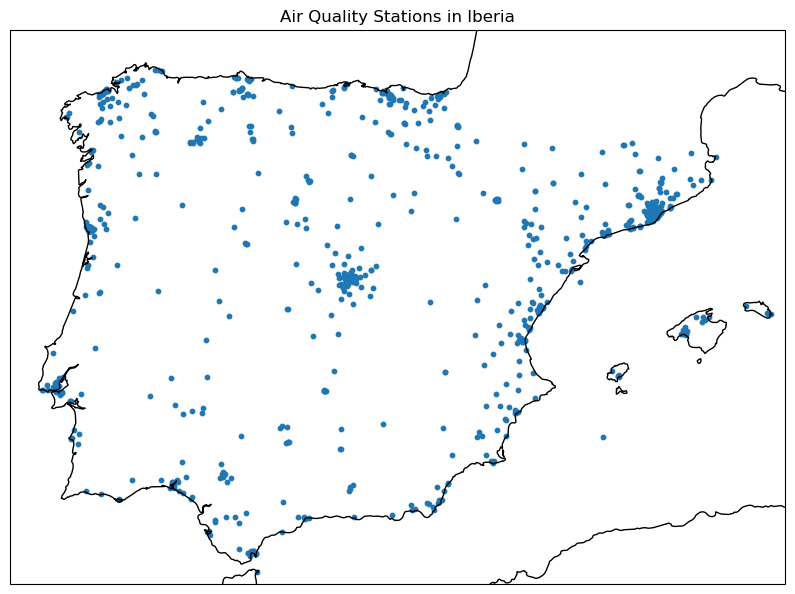

In [212]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([REGIONS["IBERIA"]["min_lon"], REGIONS["IBERIA"]["max_lon"], REGIONS["IBERIA"]["min_lat"], REGIONS["IBERIA"]["max_lat"]])
ax.scatter(df.Longitude, df.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title("Air Quality Stations in Iberia")
plt.show()

In [213]:
spain = pd.read_csv('/home/urbanaq/data/eea/ES.csv', usecols=['time', 'station', 'NO2'], index_col=['time', 'station'], parse_dates=['time'])
portugal = pd.read_csv('/home/urbanaq/data/eea/PT.csv', usecols=['time', 'station', 'NO2'], index_col=['time', 'station'], parse_dates=['time'])
andorra = pd.read_csv('/home/urbanaq/data/eea/AD.csv', usecols=['time', 'station', 'NO2'], index_col=['time', 'station'], parse_dates=['time'])

stations = pd.concat([spain, portugal, andorra])
stations = stations.join(df, how='left', on='station')

stations

,,NO2,Longitude,Latitude
time,station,,,
2022-01-01 00:00:00,ES0001R,NaN,-4.3504,39.5463
2022-01-01 01:00:00,ES0001R,0.88,-4.3504,39.5463
2022-01-01 02:00:00,ES0001R,0.43,-4.3504,39.5463
2022-01-01 03:00:00,ES0001R,0.47,-4.3504,39.5463
2022-01-01 04:00:00,ES0001R,0.53,-4.3504,39.5463
...,...,...,...,...
2022-10-03 04:00:00,AD0945A,NaN,1.7170,42.5349
2022-10-03 05:00:00,AD0945A,NaN,1.7170,42.5349
2022-10-03 06:00:00,AD0945A,NaN,1.7170,42.5349


In [214]:
# Drop stations where NO2 is NaN
stations = stations.dropna(subset=['NO2'])

# Drop stations where latitude or longitude is NaN (They are outside bbox)
stations = stations.dropna(subset=['Latitude', 'Longitude'])

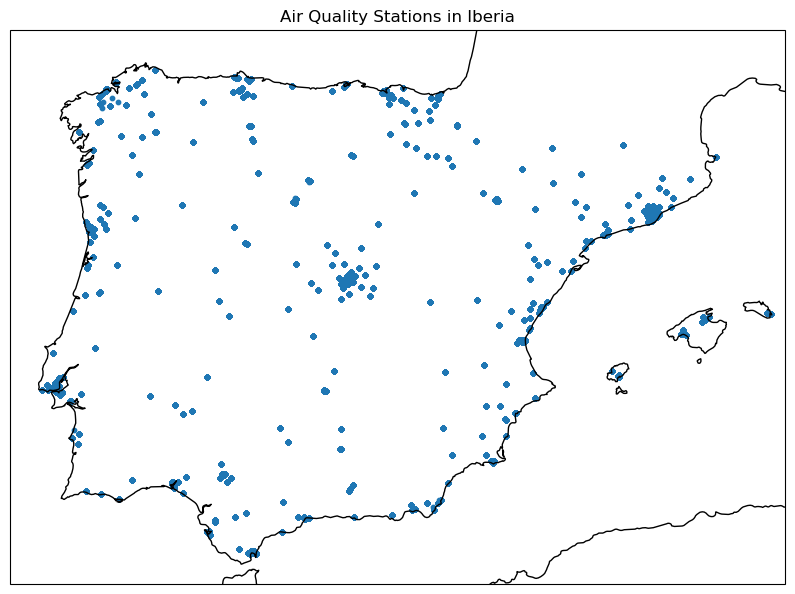

In [215]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([REGIONS["IBERIA"]["min_lon"], REGIONS["IBERIA"]["max_lon"], REGIONS["IBERIA"]["min_lat"], REGIONS["IBERIA"]["max_lat"]])
ax.scatter(stations.Longitude, stations.Latitude, transform=ccrs.PlateCarree(), s=10)
plt.title("Air Quality Stations in Iberia")
plt.show()

## 2.3. Define ROIs

In [226]:
from sklearn.cluster import DBSCAN

# Define the clustering model
dbscan = DBSCAN(eps=0.21, min_samples=15)

# Fit the model
clusters = dbscan.fit_predict(df)
df['cluster'] = clusters

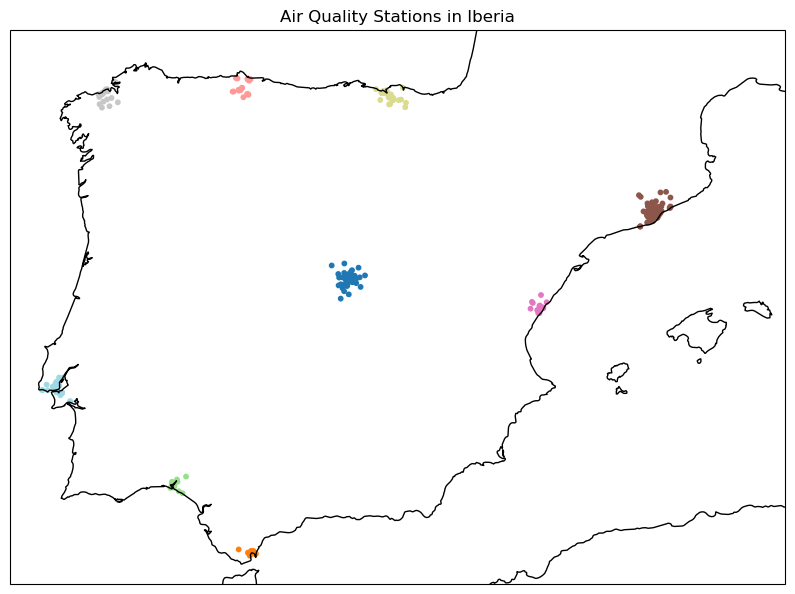

In [227]:
selected = df[df.cluster != -1]

fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution="10m")
ax.set_extent([REGIONS["IBERIA"]["min_lon"], REGIONS["IBERIA"]["max_lon"], REGIONS["IBERIA"]["min_lat"], REGIONS["IBERIA"]["max_lat"]])
scatter = ax.scatter(selected.Longitude, selected.Latitude, transform=ccrs.PlateCarree(), s=10, c=selected.cluster, cmap='tab20')
plt.title("Air Quality Stations in Iberia")
plt.show()

In [218]:
region_box = selected.groupby('cluster').agg({'Latitude': ['min', 'max'], 'Longitude': ['min', 'max']})

region_box['n'] = df[df != -1].cluster.value_counts()
region_box['area (km²)'] = 111*(region_box['Latitude']['max'] - region_box['Latitude']['min']) * 111*(region_box['Longitude']['max'] - region_box['Longitude']['min'])
region_box['area (hm²)'] = region_box['area (km²)'] * 100
region_box['density (km²)'] = region_box['n'] / region_box['area (km²)']
region_box['density (hm²)'] = region_box['n'] / region_box['area (hm²)']

region_box

Latitude          Longitude           n   area (km²)     area (hm²)  \
             min      max       min     max                                   
cluster                                                                       
0        40.1192  40.6646   -4.0143 -3.3779  49  4276.527432  427652.743176   
1        36.1362  36.2339   -5.6635 -5.3419  17   387.129763   38712.976272   
2        37.1041  37.3613   -6.9641 -6.6769  15   910.125657   91012.565664   
3        43.2561  43.5589   -5.9857 -5.6461  21  1266.979272  126697.927248   
4        41.2391  41.7793    1.8385  2.4433  72  4025.430380  402543.038016   
5        39.8922  40.1750   -0.2333  0.0728  15  1066.568351  106656.835068   
6        43.0935  43.4916   -8.5717 -8.1944  27  1850.652765  185065.276473   
7        43.1005  43.4059   -3.2206 -2.6379  31  2192.603022  219260.302218   
8        38.5242  38.8961   -9.4294 -8.8942  23  2452.382682  245238.268248   

        density (km²) density (hm²)  
                                     
cluster                              
0            0.011458      0.000115  
1            0.043913      0.000439  
2            0.016481      0.000165  
3            0.016575      0.000166  
4            0.017886      0.000179  
5            0.014064      0.000141  
6            0.014589      0.000146  
7            0.014138      0.000141  
8            0.009379      0.000094

In [219]:
stations = stations.join(df['cluster'], on='station')
stations = stations[stations.cluster != -1]

stations

,,NO2,Longitude,Latitude,cluster
time,station,,,,
2022-01-01 00:00:00,ES0041A,9.0,-2.9457,43.2588,7
2022-01-01 01:00:00,ES0041A,10.0,-2.9457,43.2588,7
2022-01-01 02:00:00,ES0041A,4.0,-2.9457,43.2588,7
2022-01-01 03:00:00,ES0041A,2.0,-2.9457,43.2588,7
2022-01-01 04:00:00,ES0041A,5.0,-2.9457,43.2588,7
...,...,...,...,...,...
2022-12-31 20:00:00,PT03104,10.5,-9.4294,38.7014,8
2022-12-31 21:00:00,PT03104,7.4,-9.4294,38.7014,8
2022-12-31 22:00:00,PT03104,7.2,-9.4294,38.7014,8


## 2.1. Temporal Resampling